In [172]:
%matplotlib notebook

In [212]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import colors
import copy
from time import sleep
import matplotlib.animation as animation
import time
import matplotlib.patches as mpatches

[Below] À installer sur son env python --> c'est pour les Moran Index

In [198]:
import pysal

## Fonctions pour rechercher les voisins

In [174]:
def inter(x, a):
    if x//a not in [0, 1]:
        return "error"
    else:
        if x//a == 0:
            return 1
        return -1

In [175]:
inter(10,10), inter(0,10)

(-1, 1)

In [176]:
def neighbor(node, shape): # retourne une liste de voisins [x,y]
    x, y = node[0], node[1]
    max_index = shape - 1

    pos_x = x % max_index
    pos_y = y % max_index

    # node is not on the edge of the grid
    if pos_x != 0 and pos_y != 0:
        return ([(x - 1, y), (x - 1, y + 1), (x, y + 1), (x + 1, y + 1), (x + 1, y), (x + 1, y - 1), (x, y - 1),
                 (x - 1, y - 1)])

    # node is on one of the corner
    elif pos_x == 0 and pos_y == 0:
        return ([(x + inter(x, max_index), y), (x + inter(x, max_index), y + inter(y, max_index)),
                 (x, y + inter(y, max_index))])

    # other cases
    else:
        if pos_x == 0:
            return ([(x, y + 1), (x + inter(x, max_index), y + 1), (x + inter(x, max_index), y),
                     (x + inter(x, max_index), y - 1), (x, y - 1)])
        else:
            return ([(x + 1, y), (x + 1, y + inter(y, max_index)), (x, y + inter(y, max_index)),
                     (x - 1, y + inter(y, max_index)), (x - 1, y)])

In [177]:
neighbor([2,3],4)

[(3, 3), (3, 2), (2, 2), (1, 2), (1, 3)]

## Fonctions pour calculer l'utility

In [178]:
def fractionFriends(grid, node, nodeType): # retourne une fraction d'amis, utile pour utility
    # important de specifier le nodeType car sinon cela ne marche pas avec les emptycases
    size = len(grid)
    nb_alike = 0  # type: int
    surroundings = 0
    neighbors = neighbor(node, size)
    for n in neighbors:
        currentNeighborType = grid[n[0]][n[1]][1]
        if  currentNeighborType != 0: # recupere le type de l'agent et verifie qu'il est non nul
            surroundings += 1
            if grid[n[0]][n[1]][1] == nodeType:
                nb_alike += 1        
    if surroundings > 0:
        return nb_alike / surroundings
    else: 
        return 1

In [179]:
def utility(grid, node, nodeType) : # retourne un float
    frac=fractionFriends(grid,node,nodeType)
    threshold = grid[node[0]][node[1]][0]
    if frac >= threshold:
        return 1 
    else : 
        return frac/threshold
        

## Fonctions pour relocaliser

In [180]:
def findIndex(emptyCases,node): # to find a specific node in emptyCases (useful for relocate)
    index = -1
    for i in range(len(emptyCases)):
        if ((emptyCases[i][0]==node[0]) and (emptyCases[i][1]==node[1])) :
            index = i
            break
    return (index)

In [181]:
findIndex(np.array([[3,3],[2,5],[1,8]]),[1,8])

2

In [182]:
def relocate(node,u,emptyCases,w,grid): # relocate dans la grid, w=nb de cases vides qu'on regarde
    
    pickedEmptyCases = np.random.permutation(emptyCases)[:w]
    bestPlaceFound, newPlaceFound = False, False # bestPlaceFound to stop when u=1, newPlaceFound to know if we relocate
    nodeType = grid[node[0]][node[1]][1]
    i=0
    maxU = u
    bestNode = node
    while not bestPlaceFound and i < w :
        currentU = utility(grid,pickedEmptyCases[i],nodeType)
        if maxU <= currentU: 
            maxU = currentU
            bestNode = pickedEmptyCases[i]
            newPlaceFound = True
        if currentU == 1 :
            bestPlaceFound = True
        i+=1
    if newPlaceFound:
        grid[bestNode[0]][bestNode[1]] = copy.deepcopy(grid[node[0]][node[1]]) # on met la valeur dans la nouvelle case
        grid[node[0]][node[1]] = [0,0]
    
        index = findIndex(emptyCases,[bestNode[0],bestNode[1]])
        emptyCases = np.delete(emptyCases,index,axis=0)
        emptyCases = np.append(emptyCases,[[node[0],node[1]]],axis=0)

    return(emptyCases) #on renvoit la nouvelle liste des noeux vides
    
        

## Fonctions d'initialisation de la grid

In [183]:
def randomNodes(N): # genere une listes de coordonnées (x,y)
    grid = np.zeros((N,N,2))
    for i in range(N):
        for j in range (N):
            grid[i][j] = [i,j]
    shuffleGrid = np.random.permutation(grid)
    nodes = []
    for i in range(N):
        for j in range(N):
            nodes.append(shuffleGrid[i][j])
    return (np.random.permutation(nodes)) # attention ca renvoit des floats
            

In [184]:
randomNodes(3)


array([[2., 0.],
       [0., 2.],
       [0., 0.],
       [0., 1.],
       [2., 2.],
       [1., 0.],
       [1., 1.],
       [1., 2.],
       [2., 1.]])

In [185]:
def initializeRandom(distrib, nbEmpty, N, p): # retourne une grille initiale random, distrib=beta de division des threshold au sein des agents
    
    F1, F2 = distrib[0], distrib[1]
    
    nbCases = N*N
    
    grid = np.zeros((N,N,2))
    nodes = randomNodes(N)
    f, nodeType, count = 0, 0, 0
    
    palier0 = nbEmpty
    palier1 = int(nbEmpty + (N*N - nbEmpty)*p/2)
    palier2 = int(nbEmpty + (N*N - nbEmpty)*p)
    palier3 = int(nbEmpty + (N*N - nbEmpty)*(p+1)/2)
    
    for n in range(len(nodes)):
        i,j = int(nodes[n][0]),int(nodes[n][1])
        grid[i,j] = [f, nodeType]
        count += 1
        
        if (count == palier0 ):
            f, nodeType = F1, 1
        if (count == palier1 ):
            f, nodeType = F2, 1
        if (count == palier2 ):
            f, nodeType = F1, 2
        if (count == palier3 ):
            f, nodeType = F2, 2
        
    emptyCases = nodes[:nbEmpty] 
    
    return(grid,emptyCases.astype(int))
    

## Fonctions de transformation de la grid finale

In [186]:
def returnTypeGrid(grid,N): #renvoie les types (1 ou 2)
    typeGrid = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            typeGrid[i][j] = grid[i][j][1]
    return(typeGrid)

def returnThresholdGrid(grid,N): # renvoie les thresholds (F1 ou F2)
    thresholdGrid = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            thresholdGrid[i][j] = grid[i][j][0]
    return(thresholdGrid)

## Notre fonction globale

In [187]:
def schelling(distrib, nbEmpty=50, N=50, n_iterations_max=100,p=0.5,m=0.01,w=30):
    
    # On initialise
    grid, emptyCases = initializeRandom(distrib,nbEmpty,N,p) 
    placementsColor = [copy.deepcopy(returnTypeGrid(grid,N))]
    placementsThreshold = [copy.deepcopy(returnThresholdGrid(grid,N))]
    
    # Go boucle 
    t = 0
    while t<n_iterations_max :
        i,j = np.random.randint(N,size=2)
        if grid[i][j][1] != 0 : # on checke si c'est pas une case vide
            u = utility(grid=grid, node=[i,j], nodeType=grid[i][j][1])
            randNb = np.random.random()
            if ((u<1) or ((u==1) and (randNb<m))):
                emptyCases = relocate(node=[i,j],u=u,emptyCases=emptyCases,w=w,grid=grid)
        t += 1
        placementsColor.append(copy.deepcopy(returnTypeGrid(grid,N)))
        placementsThreshold.append(copy.deepcopy(returnThresholdGrid(grid,N)))
        
        
    return(placementsColor,placementsThreshold)     

## Test sur le temps de calcul

In [188]:
t1=time.time()
placements = schelling(distrib=[0.4,0.4], n_iterations_max=1000)
t2=time.time()
print("time",t2-t1)
t1=time.time()
placements = schelling(distrib=[0.4,0.4], n_iterations_max=2000)
t2=time.time()
print("iter*2",t2-t1)
t1=time.time()
placements = schelling(distrib=[0.4,0.4], n_iterations_max=50000)
t2=time.time()
print("iter*50",t2-t1)

time 4.0569047927856445


KeyboardInterrupt: 

Je mets environ 1,6 secondes pour traiter 1000 agents sur mon ordi, en doublant environ 3,5 secondes et 75 secondes quand je multiplie 50 secondes, on est à peu près linéaire avec le nombre n d'agents traités. **Si on veut traiter 2000 steps * 2500 agents = 50 000 000 boucles ds Schelling, ca nous fait du 7500s pour executer l'algo...**

## La simulation au propre

In [189]:
def simulation(distrib,n_iterations_max):
    ## resultats :
    t1=time.time()
    placementsColor,placementsThreshold = schelling(distrib=distrib, n_iterations_max=n_iterations_max)
    t2=time.time()
    simulationTime = round(t2-t1,4)
    
    ## visualisation :
    
    values1 = np.array([0.,1.,2.])
    labels1 = np.array(['Empty','Type 1','Type2'])
    values2 = np.unique(placementsThreshold[-1].ravel())
    
    # COLORS
    fig = plt.figure()
    ax = fig.add_subplot(211)
    plt.ion()
    ax.clear()
    fig.canvas.draw()
    im = ax.imshow(placementsColor[-1])

    # colormap used by imshow
    colors = [ im.cmap(im.norm(value)) for value in values1]
    # create a patch (proxy artist) for every color 
    patches = [ mpatches.Patch(color=colors[i], label='{l}'.format(l=labels1[i]) ) for i in range(len(values1)) ]

    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )


    # THRESHOLDS
    ax = fig.add_subplot(212)
    plt.ion()
    ax.clear()
    fig.canvas.draw()
    im = ax.imshow(placementsThreshold[-1])

    # colormap used by imshow
    colors = [ im.cmap(im.norm(value)) for value in values2]
    # create a patch (proxy artist) for every color 
    patches = [ mpatches.Patch(color=colors[i], label='Threshold F={l}'.format(l=values2[i]) ) for i in range(1,len(values2)) ]

    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    fig.suptitle('N_iterations : {0}, Thresholds : {1}, Time : {2}'.format(n_iterations_max,distrib,simulationTime))



<IPython.core.display.Javascript object>


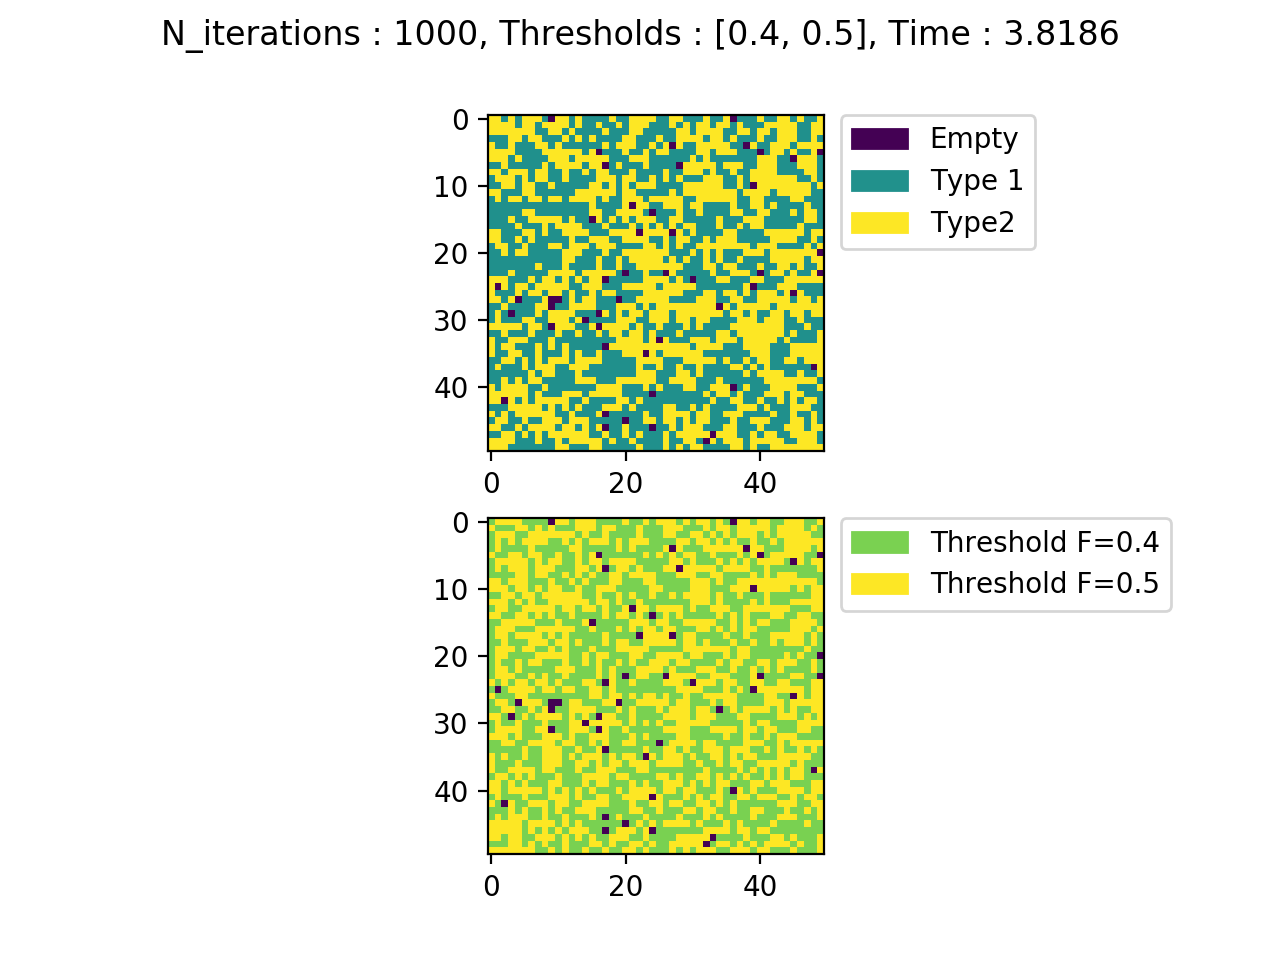

In [218]:
simulation([0.4,0.5],1000)

In [226]:
def evolutionOfI(distrib,n_iterations_max):
    placementsColor,placementsThreshold = schelling(distrib=distrib, n_iterations_max=n_iterations_max)
    x, moranIc, moranIt = [], [], []
    i=0
    while i<n_iterations_max :
        A,B = placementsColor[i],placementsThreshold[i]
        # Create the matrix of weigthts
        wA = pysal.lat2W(A.shape[0], A.shape[1])
        wB = pysal.lat2W(B.shape[0], B.shape[1])
        # Crate the pysal Moran object
        miA = pysal.Moran(A, wA)
        miB = pysal.Moran(B, wB)
        x.append(i)
        moranIc.append(miA.I)
        moranIt.append(miB.I)
        i += 100
    fig =plt.figure()
    plt.plot(x, moranIc, 'r--', label='Ic')
    plt.plot(x, moranIt, 'b--', label='It')
    plt.xlabel('Iterations')
    plt.ylabel('Moran I')
    plt.legend(loc="best")
    plt.show()

<IPython.core.display.Javascript object>


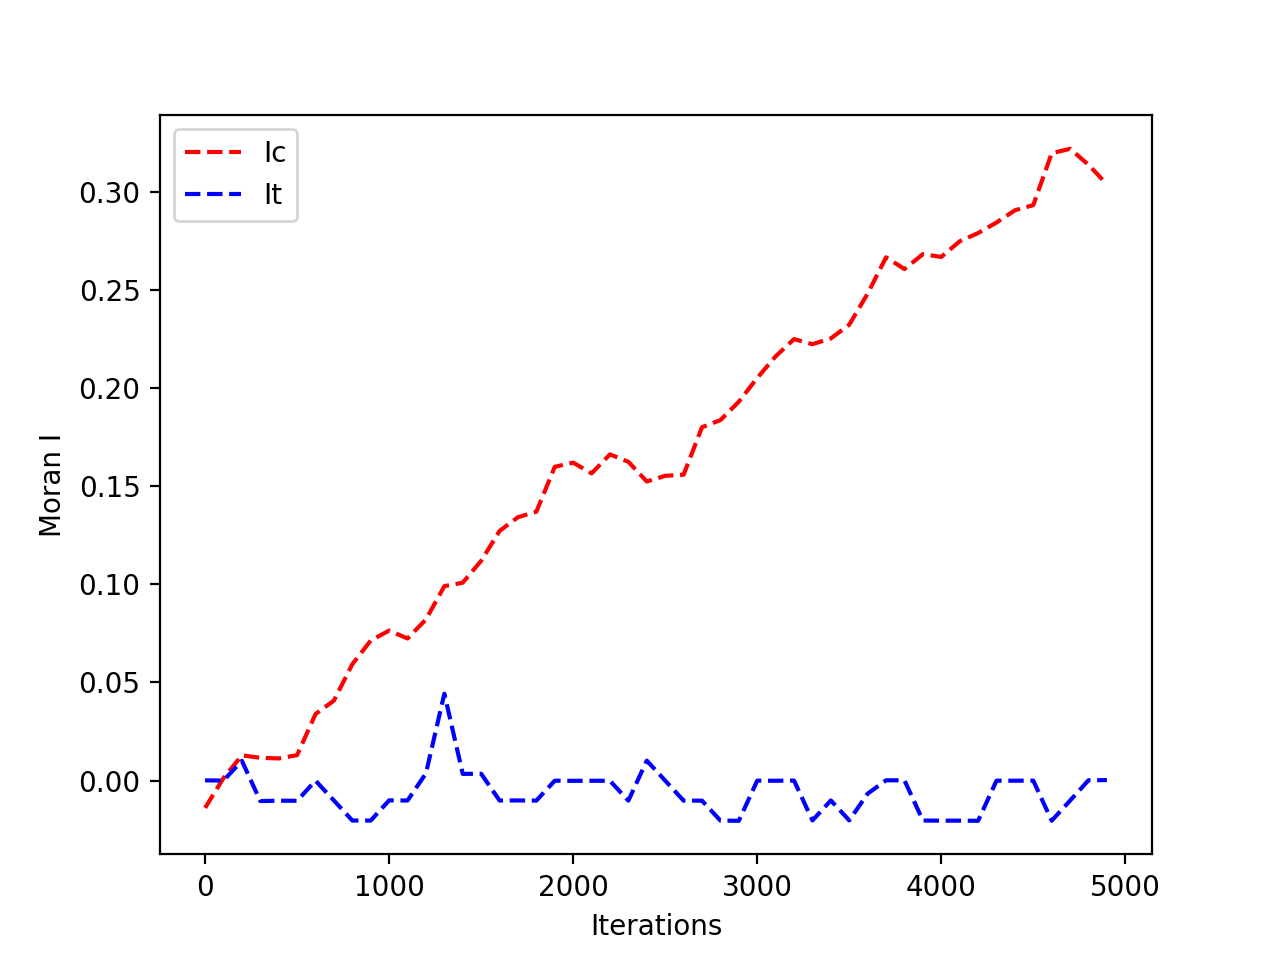

In [227]:
evolutionOfI([0.4,0.4],50000)

## En continu --> c'est assez long bizarrement

<IPython.core.display.Javascript object>


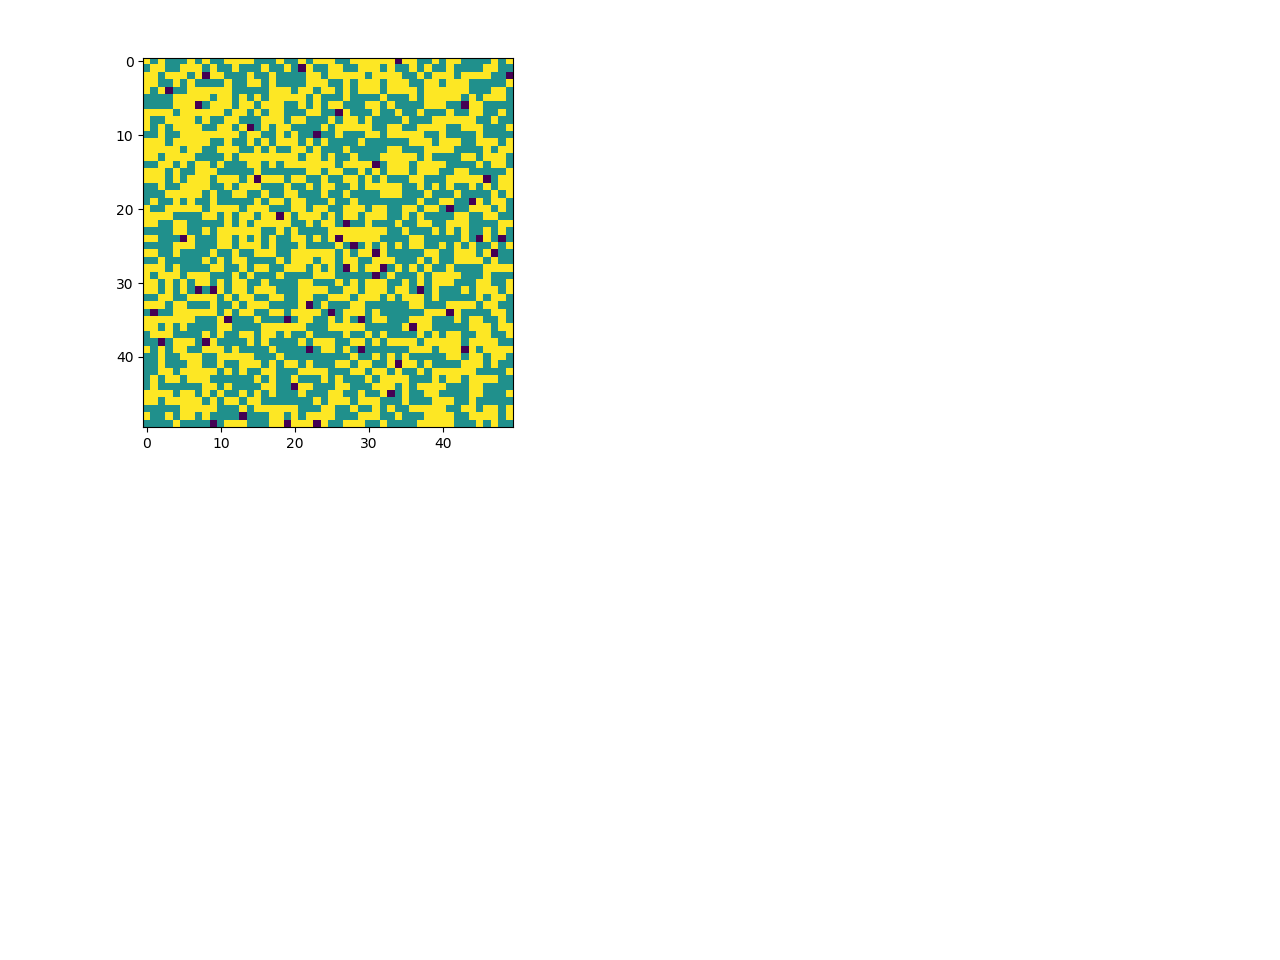

KeyboardInterrupt: 

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

ax.clear()
fig.canvas.draw()
#sleep(1)
for i in range(len(placements4)):
    ax.clear()
    ax.imshow(placements4[i])
    fig.canvas.draw()
    sleep(0.000000001)

In [171]:
! conda install -c anaconda pysal 



/bin/sh: conda: command not found
